In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop, SGD

In [16]:
df = pd.read_csv("../processed_adhdata.csv")
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD->1, Control->0

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape(
    (window_count, frequency_count, numeric_df.shape[1])
)

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

# Standardize across the entire dataset
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat  = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(X_train.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

Train shape: (6623, 77, 19, 1)


In [17]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  
        # -> (N, 1, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [18]:
class EEGCNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(2)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, X_train.shape[1], X_train.shape[2])
            out = self._forward_features(dummy)
            flat_dim = out.numel()
        
        self.fc1 = nn.Linear(flat_dim, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 2)  # ADHD vs Control

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def fit(self, train_loader, test_loader, epochs, criterion, optimizer):
        best_val_loss = float('inf')
        patience = 30
        no_improve = 0

        train_losses, train_accs = [], []
        val_losses, val_accs     = [], []

        for epoch in range(epochs):
            # --- Train ---
            self.train()
            train_loss, train_correct = 0.0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = self(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * xb.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()

            train_loss /= len(train_ds)
            train_acc  = train_correct / len(train_ds)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # --- Validate ---
            self.eval()
            val_loss, val_correct = 0.0, 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = self(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()

            val_loss /= len(test_ds)
            val_acc  = val_correct / len(test_ds)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_loss - train_loss > 0.2:
                print("Overfitting detected.")
                break
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        self.load_state_dict(best_state)
        return {
            "train_accs": np.array(train_accs),
            "train_losses": np.array(train_losses),
            "val_accs":   np.array(val_accs),
            "val_losses": np.array(val_losses)
        }

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]  # number of electrodes
model = EEGCNN(input_size).to(device)

history = model.fit(train_loader, test_loader,
                    epochs=200,
                    criterion=nn.CrossEntropyLoss(),
                    optimizer=RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-5))

Epoch 001 | Train Loss: 0.6811 Acc: 0.5861 | Val Loss: 0.6611 Acc: 0.5918
Epoch 002 | Train Loss: 0.6579 Acc: 0.6168 | Val Loss: 0.6303 Acc: 0.6238
Epoch 003 | Train Loss: 0.6285 Acc: 0.6657 | Val Loss: 0.6073 Acc: 0.6944
Epoch 004 | Train Loss: 0.5933 Acc: 0.6962 | Val Loss: 0.5554 Acc: 0.7349
Epoch 005 | Train Loss: 0.5657 Acc: 0.7229 | Val Loss: 0.5648 Acc: 0.6993
Epoch 006 | Train Loss: 0.5448 Acc: 0.7257 | Val Loss: 0.5010 Acc: 0.7482
Epoch 007 | Train Loss: 0.5233 Acc: 0.7426 | Val Loss: 0.4916 Acc: 0.7591
Epoch 008 | Train Loss: 0.5113 Acc: 0.7527 | Val Loss: 0.4610 Acc: 0.7633
Epoch 009 | Train Loss: 0.4882 Acc: 0.7661 | Val Loss: 0.4458 Acc: 0.7874
Epoch 010 | Train Loss: 0.4734 Acc: 0.7728 | Val Loss: 0.4597 Acc: 0.7681
Epoch 011 | Train Loss: 0.4622 Acc: 0.7726 | Val Loss: 0.4182 Acc: 0.8031
Epoch 012 | Train Loss: 0.4435 Acc: 0.7845 | Val Loss: 0.4166 Acc: 0.8001
Epoch 013 | Train Loss: 0.4288 Acc: 0.7901 | Val Loss: 0.3961 Acc: 0.8110
Epoch 014 | Train Loss: 0.4199 Acc: 0.

In [13]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8780193236714976
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       925
           1       0.92      0.79      0.85       731

    accuracy                           0.88      1656
   macro avg       0.89      0.87      0.87      1656
weighted avg       0.88      0.88      0.88      1656

[[876  49]
 [153 578]]


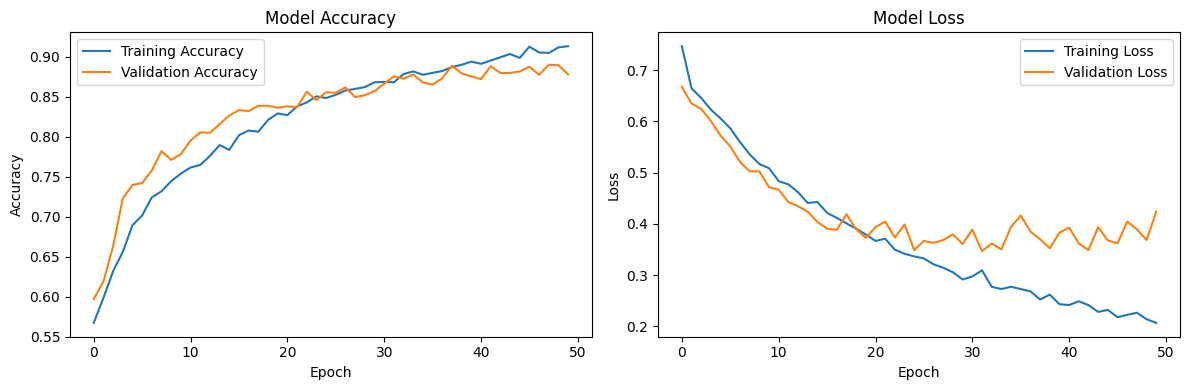

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()